In [1]:
import skimage.io
import numpy as np
from skimage import exposure
import os
import matplotlib.pyplot as plt
% matplotlib inline
import matplotlib.patches as patches

In [3]:
def generate_error_visualization(exp, fov, dimensions, mag):
    
    gt = os.path.join(img_dir,"GT", exp, fov)
    gray = os.path.join(img_dir, "GreyScale", exp, fov)
    mrcnn_run037 = os.path.join(img_dir, "Inference/MRCNN/Run37/mrcnn", exp, fov)
    mrcnn_run003 = os.path.join(img_dir, "Inference/MRCNN/Run03/mrcnn", exp, fov)
    fpn_w_run010 = os.path.join(img_dir, "Inference/UW2/Run10/watershed-2",exp, "images", fov)
    fpn_w_run004 = os.path.join(img_dir, "Inference/UW2/Run04/watershed-2", exp, "images", fov)
    kaggle = os.path.join(img_dir, "./Inference/MRCNN/Run44/kaggle-2nd", exp, fov)
    
    gt_img = skimage.io.imread(gt)
    gray_img = skimage.io.imread(gray)
    mrcnn_run037_img = skimage.io.imread(mrcnn_run037)
    mrcnn_run003_img = skimage.io.imread(mrcnn_run003)
    fpn_w_run010_img = skimage.io.imread(fpn_w_run010)
    fpn_w_run004_img = skimage.io.imread(fpn_w_run004)
    kaggle_img = skimage.io.imread(kaggle)
   

    #Increase the contrast of the gray scale image
    v_min, v_max = np.percentile(gray_img, (0.2, 99.8))
    gray_contrast = exposure.rescale_intensity(gray_img, in_range=(v_min, v_max))

    #fig 2: MRCNN run003, FPN run004
    gt_per, gt_xor = get_images(gt_img,gt_img)
    mrcnn_per, mrcnn_xor = get_images(mrcnn_run003_img,gt_img)
    watershed_per, watershed_xor = get_images(fpn_w_run004_img,gt_img)
    kaggle_per, kaggle_xor = get_images(kaggle_img, gt_img)
    
    fig_name = "{0}_{1}_baseline.tif".format(exp, fov.replace(".tif", ""))
    plot_visualization(gray_contrast, gt_per, mrcnn_per, mrcnn_xor, watershed_per, watershed_xor, dimensions, fig_name, mag = mag)
    
    #fig 5: MRCNN run037, FPN run010
    mrcnn_per, mrcnn_xor = get_images(mrcnn_run037_img,gt_img)
    watershed_per, watershed_xor = get_images(fpn_w_run010_img,gt_img)
    
    fig_name = "{0}_{1}_all_images.tif".format(exp, fov.replace(".tif", ""))
    plot_visualization(gray_contrast, gt_per, mrcnn_per, mrcnn_xor, watershed_per, watershed_xor, dimensions, fig_name, 
                       kaggle_per = kaggle_per, 
                       kaggle_xor = kaggle_xor,
                      mag = mag)
    

In [121]:
def plot_visualization(gray_contrast, gt_per, mrcnn_per, mrcnn_xor, watershed_per, watershed_xor, dimensions, figure_name,
                      kaggle_per = None, kaggle_xor = None, mag = 1):

    
    nfigures = 5
    if kaggle_per is not None: 
        nfigures += 1
    
    if kaggle_xor is not None: 
        nfigures += 1

    dim = dimensions
    
    fig, axes = plt.subplots(1,nfigures, figsize=(32,32))
    fig.tight_layout(pad=-2.6)


    #nuclei_cmap = "nipy_spectral"
    #inf_alpha = 0.5
    #err_alpha = 0.3
    
    nuclei_cmap = "gist_ncar"
    inf_alpha = 0.7
    err_alpha = 0.5
    
    #convert zero to black color in gitst_ncar
    if nuclei_cmap == "gist_ncar":
        from matplotlib import cm
        from matplotlib.colors import ListedColormap
        gist_ncar = cm.get_cmap('gist_ncar', 256)
        newcolors = gist_ncar(np.linspace(0, 1, 256))
        black = np.array([0, 0, 0, 1])
        magneta = np.array([1, 0, 1, 1])
        newcolors[0, :] = black
        newcolors[255, :] = magneta
        newcmp = ListedColormap(newcolors)
        nuclei_cmap = newcmp
    
    print("mrcnn:", np.max(mrcnn_xor))
    print("watershed:", np.max(watershed_xor))
    print("Kaggle:", np.max(kaggle_xor))
    
    axes_id = -1

    axes_id += 1
    axes[axes_id].imshow(gt_per[dim[0]:dim[1], dim[2]:dim[3]], cmap=nuclei_cmap)
    axes[axes_id].imshow(gray_contrast[dim[0]:dim[1], dim[2]:dim[3]], cmap=plt.cm.gray,  alpha= inf_alpha)

    axes_id += 1
    axes[axes_id].imshow(mrcnn_per[dim[0]:dim[1], dim[2]:dim[3]], cmap=nuclei_cmap)
    axes[axes_id].imshow(gray_contrast[dim[0]:dim[1], dim[2]:dim[3]], cmap=plt.cm.gray,  alpha= inf_alpha)

    axes_id += 1
    axes[axes_id].imshow(watershed_per[dim[0]:dim[1], dim[2]:dim[3]], cmap=nuclei_cmap)
    axes[axes_id].imshow(gray_contrast[dim[0]:dim[1], dim[2]:dim[3]], cmap=plt.cm.gray,  alpha= inf_alpha)
    
    if kaggle_per is not None:
        axes_id += 1
        axes[axes_id].imshow(kaggle_per[dim[0]:dim[1], dim[2]:dim[3]], cmap=nuclei_cmap)
        axes[axes_id].imshow(gray_contrast[dim[0]:dim[1], dim[2]:dim[3]], cmap=plt.cm.gray,  alpha= inf_alpha)

    axes_id += 1
    axes[axes_id].imshow(mrcnn_xor[dim[0]:dim[1], dim[2]:dim[3]], cmap=nuclei_cmap)
    axes[axes_id].imshow(gray_contrast[dim[0]:dim[1], dim[2]:dim[3]], cmap=plt.cm.gray,  alpha= err_alpha)

    axes_id += 1
    axes[axes_id].imshow(watershed_xor[dim[0]:dim[1], dim[2]:dim[3]], cmap=nuclei_cmap)
    axes[axes_id].imshow(gray_contrast[dim[0]:dim[1], dim[2]:dim[3]], cmap=plt.cm.gray,  alpha= err_alpha)

    if kaggle_xor is not None:
        axes_id += 1
        axes[axes_id].imshow(kaggle_xor[dim[0]:dim[1], dim[2]:dim[3]], cmap=nuclei_cmap)
        axes[axes_id].imshow(gray_contrast[dim[0]:dim[1], dim[2]:dim[3]], cmap=plt.cm.gray,  alpha= err_alpha)
    

    x_loc = int((dim[1] - dim[0]) * 3 / 4)
    y_loc = int((dim[3] - dim[2]) * 7 / 8)
    print x_loc, y_loc
    
    lower_write = dim[1] - dim[0] - 20 / (500 / (dim[1] - dim[0]))
    rect = patches.Rectangle((lower_write - mag, y_loc), mag, 8, color ='w')
    axes[axes_id].add_patch(rect)

    
    
    #Turn off axis and y axis
    for axes_id in range(0, nfigures):
        axes[axes_id].get_xaxis().set_visible(False)
        axes[axes_id].get_yaxis().set_visible(False)

    fig.savefig(figure_name, bbox_inches = 'tight',pad_inches = 0)

In [6]:
def get_iou(inference, gt):
    true_objects = np.unique(gt)
    pred_objects = np.unique(inference)
    #print("ground truth nuclei:", len(true_objects))
    #print("Inference nuclei:", len(pred_objects))
    true_bins = np.append(true_objects, true_objects[-1] + 1)
    pred_bins = np.append(pred_objects, pred_objects[-1] + 1)
    intersection, xedges, yedges = np.histogram2d(gt.flatten(), inference.flatten(), bins=(true_bins, pred_bins))
    area_true = np.histogram(gt, bins = true_bins)[0]
    area_pred = np.histogram(inference, bins = pred_bins)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)
    union = area_true + area_pred - intersection
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9
    iou = intersection / union
    return iou
    

In [7]:
def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1   # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
    return true_positives, false_positives, false_negatives

In [8]:
def get_permuted_lookup(ids):
    """
    Returns a lookup table after permuting the Ids
    Arguments:
        ids: 2D numpy array 
            The 2D Ids array
    
    returns: 1D numpy array
        The permuted Ids
    """
    #Permute the instance ids for better display
    np.random.seed(2)
    max_id = np.max(ids)
    max_id = 2000
    lookup = np.random.permutation(max_id + 2)
    #Make sure background stays as background
    lookup = lookup[lookup != 0]
    lookup[0] = 0
    return lookup

In [123]:
def get_images(inference, gt):
    """
    Returns a permuted ids and errors highlights
    """
    iou = get_iou(inference, gt)
    tp, fp, fn = precision_at(0.7, iou)
    fn_indexes = np.nonzero(fn)[0] + 1
    fp_indexes = np.nonzero(fp)[0] + 1
    
    #Highlight false negative IDs from ground truth
    gt_fn = np.zeros(gt.shape)
    for nuclei_id in fn_indexes:
        gt_fn[gt == nuclei_id] = nuclei_id
        
    gt_xor_inference = np.bitwise_xor(gt != 0, inference != 0) * 2500
    lookup_gt = get_permuted_lookup(gt)
    gt_fn_permuted = lookup_gt[gt_fn.astype("uint16")]
    #highlight all the false positive nuclei in addition to xor
    np.copyto(gt_xor_inference, gt_fn_permuted, where = gt_fn != 0)
    
    lookup_inference = get_permuted_lookup(inference)
    inference_permuted = lookup_inference[inference]
    
    return [inference_permuted, gt_xor_inference]

('mrcnn:', 2500)
('watershed:', 2500)
('Kaggle:', None)
375 437
('mrcnn:', 2500)
('watershed:', 2500)
('Kaggle:', 2500)
375 437
('mrcnn:', 2500)
('watershed:', 2500)
('Kaggle:', None)
375 437
('mrcnn:', 2500)
('watershed:', 2500)
('Kaggle:', 2500)
375 437
('mrcnn:', 2500)
('watershed:', 2500)
('Kaggle:', None)
187 218
('mrcnn:', 2500)
('watershed:', 2500)
('Kaggle:', 2500)
187 218
('mrcnn:', 2500)
('watershed:', 2500)
('Kaggle:', None)
187 218
('mrcnn:', 2500)
('watershed:', 2500)
('Kaggle:', 2500)
187 218


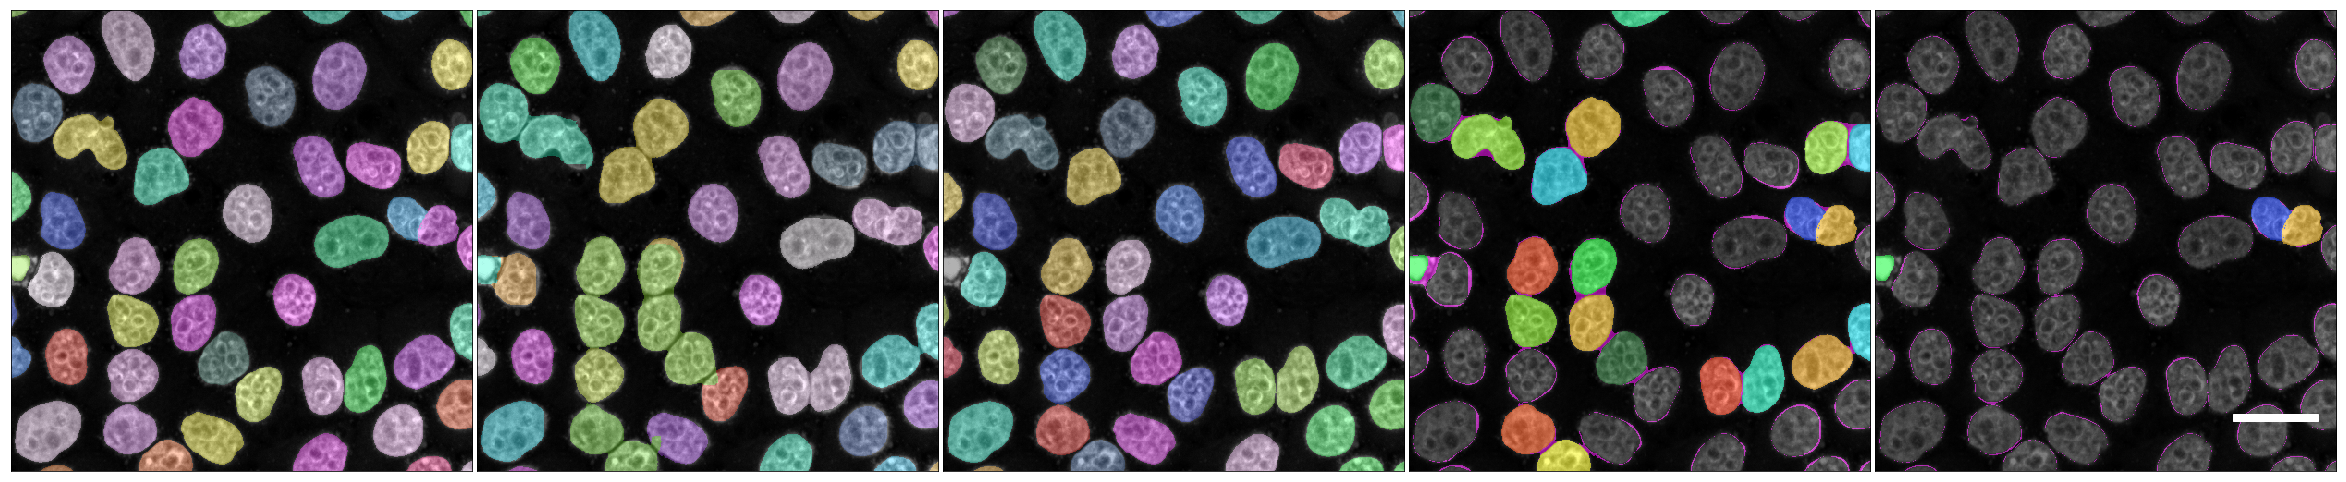

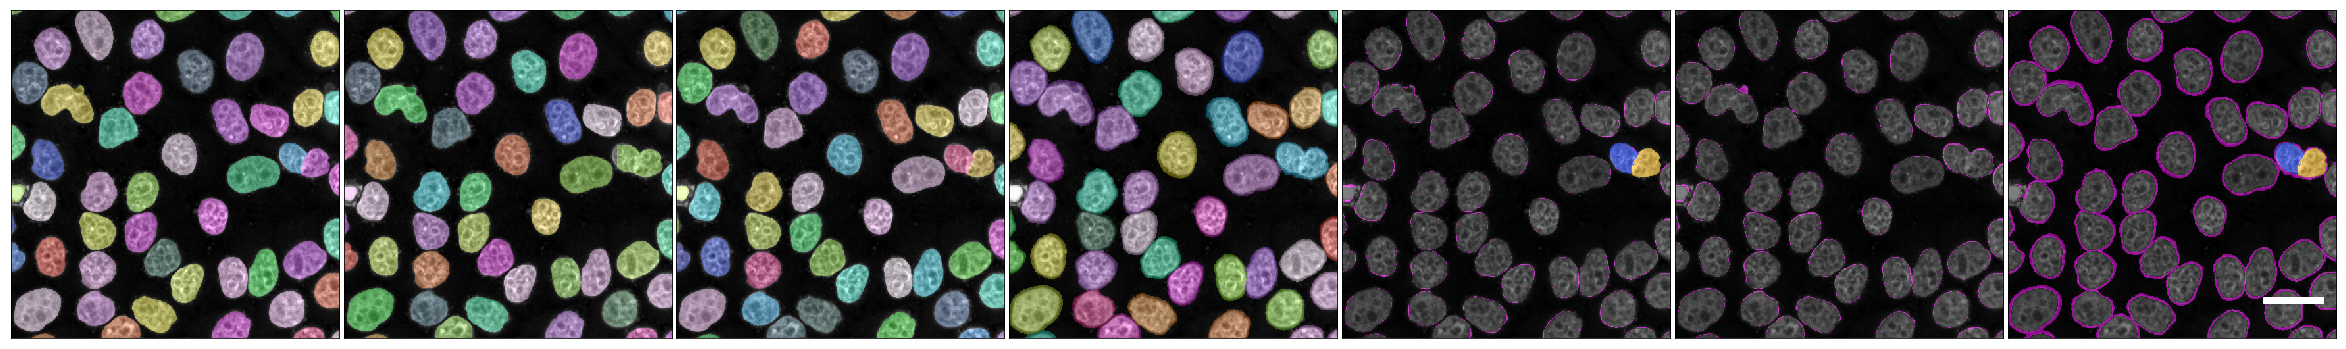

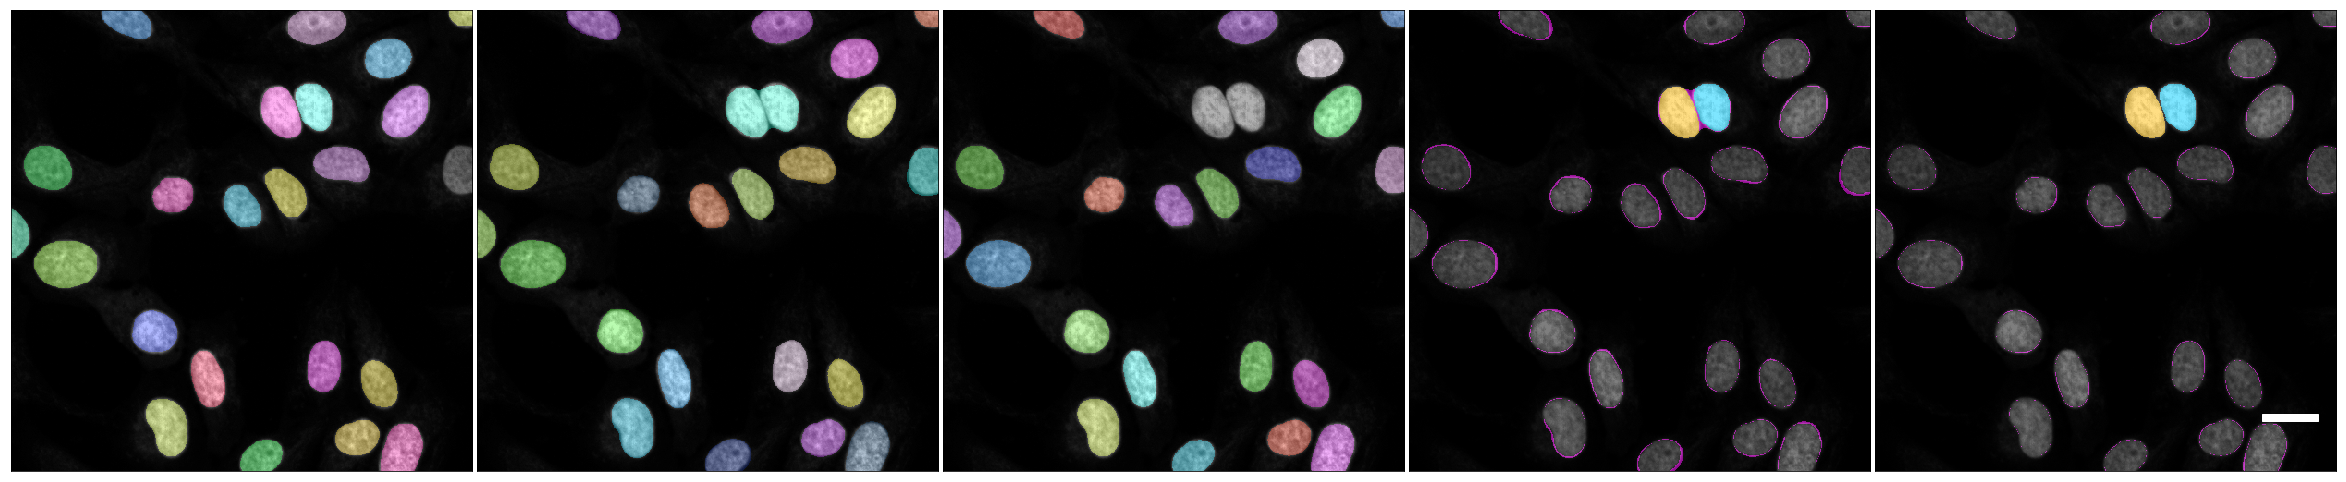

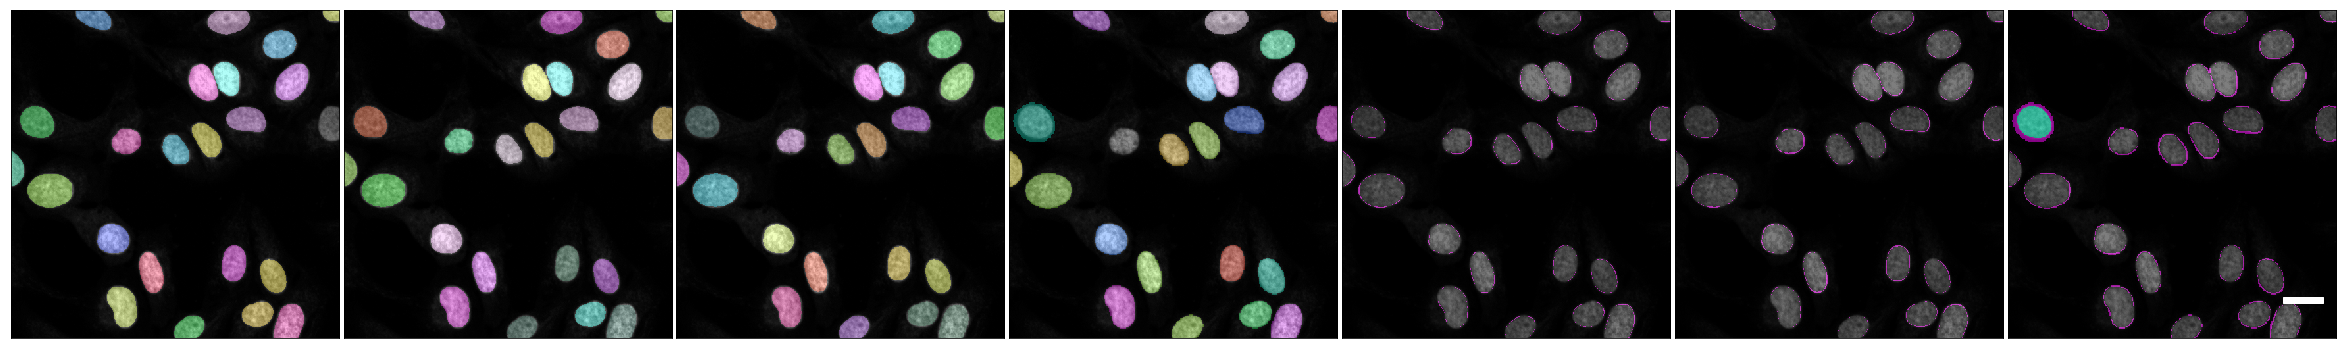

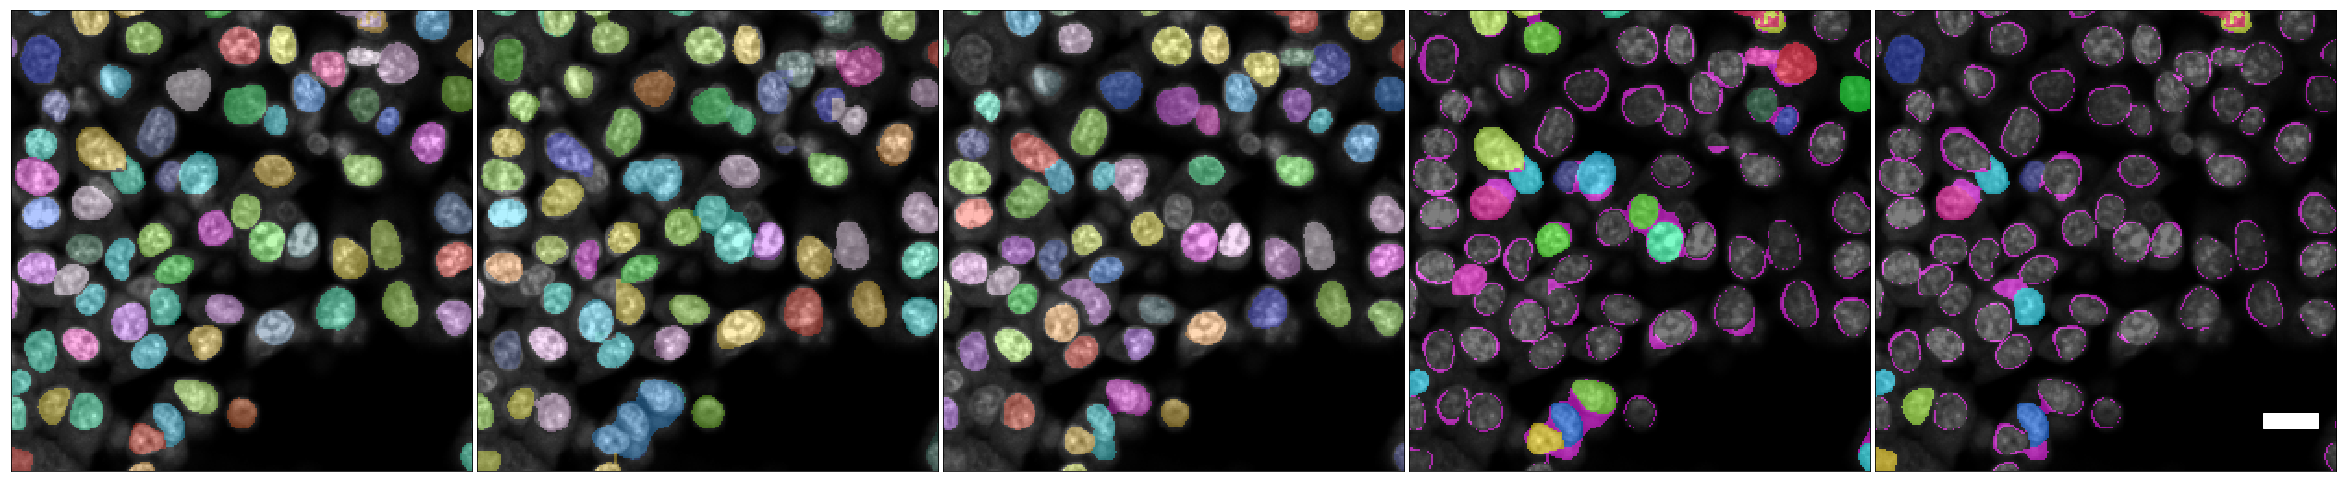

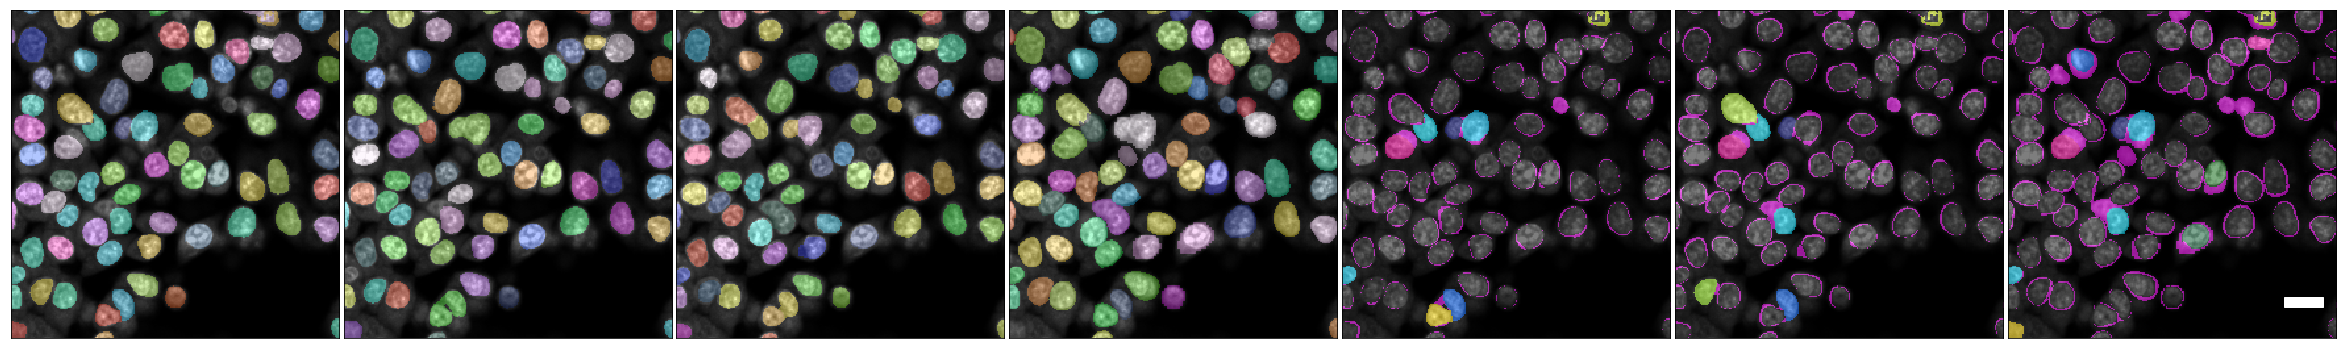

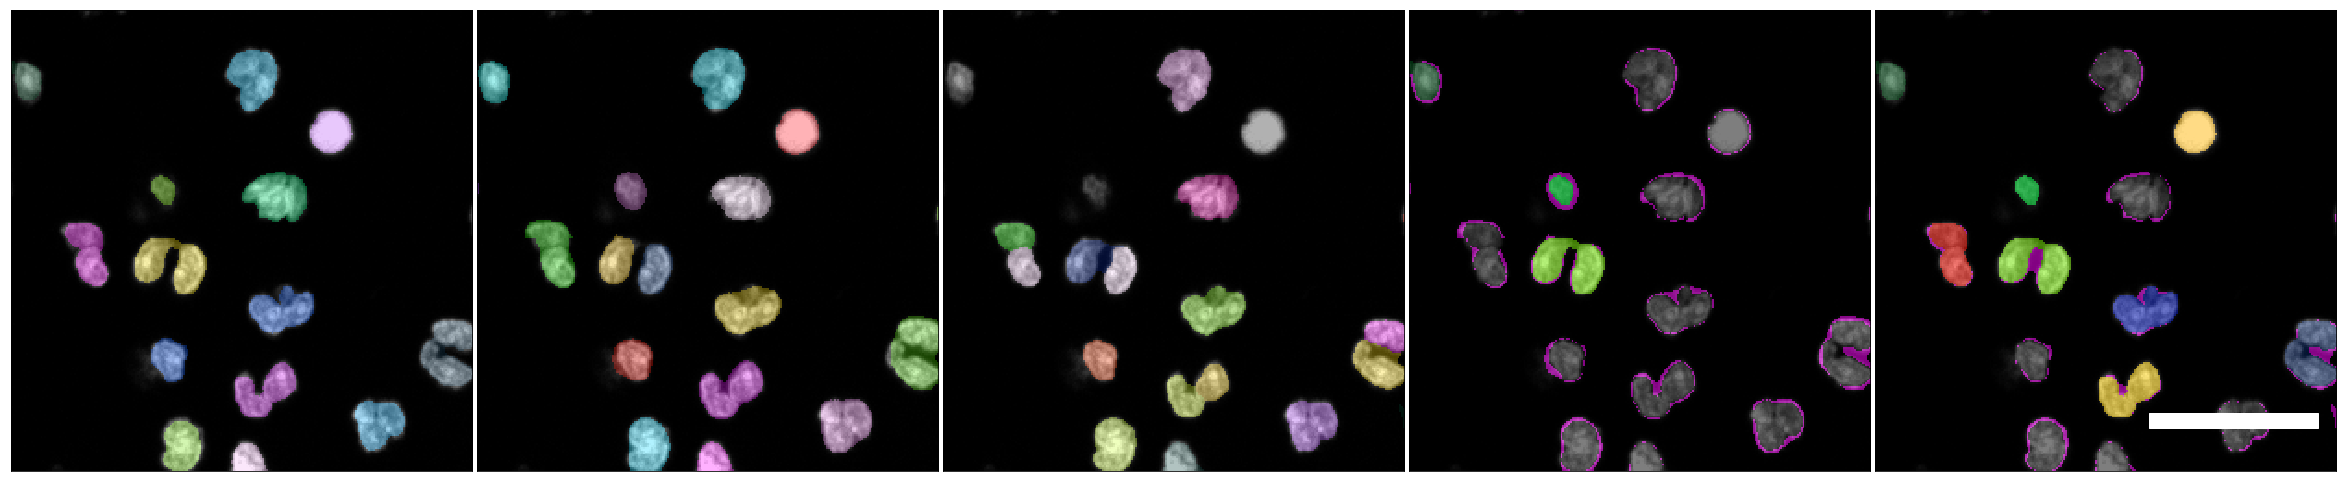

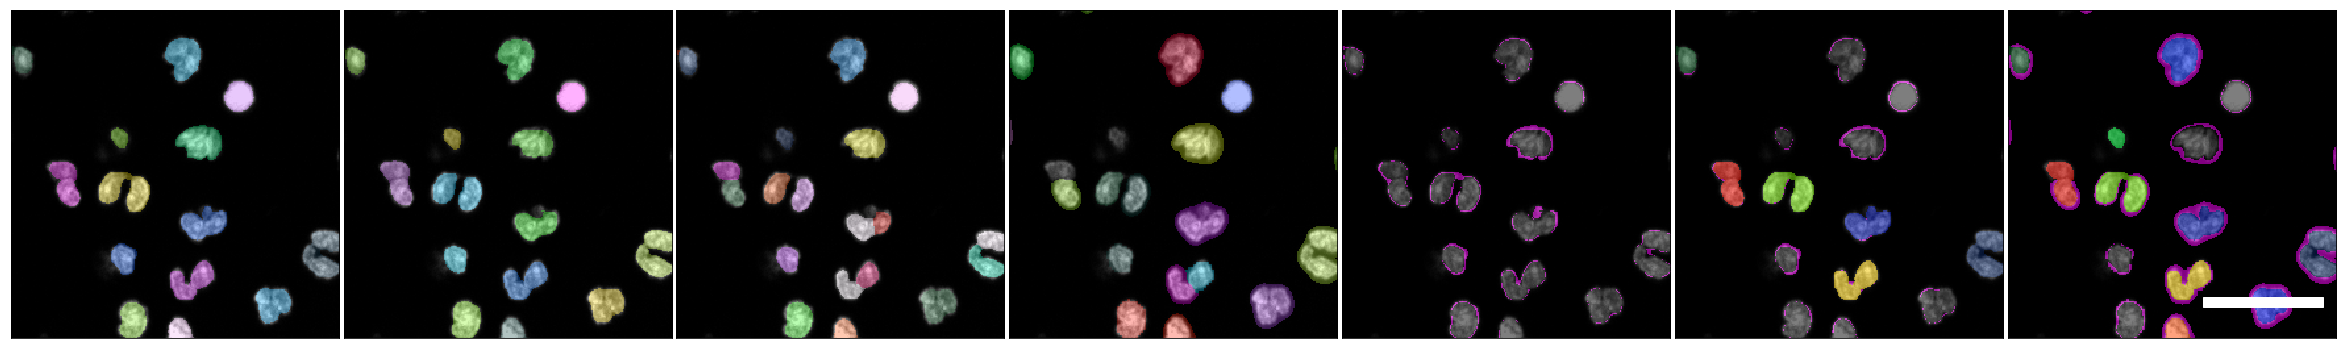

In [124]:
arg_dic = {}
img_dir = "."
exp_babe = "BABE_Biological"
fov_babe = "Plate1_E03_T0001FF001Zall.tif"
roi_babe = (500, 1000, 500, 1000)
mag_babe = int(20/0.216)

generate_error_visualization(exp_babe, fov_babe, roi_babe, mag_babe)


exp_laurent = "HiTIF_Laurent_Technical"
fov_laurent = "AUTO0496_J14_T0001F001L01A01Z01C01.tif"
roi_laurent = (500, 1000, 500, 1000)
mag_laurent = int(20/0.325)
generate_error_visualization(exp_laurent, fov_laurent, roi_laurent, mag_laurent)

exp_colorectal = "HiTIF_Colorectal_Biological"
fov_colorectal = "AUTO0218_N07_T0001F004L01A01Z01C01.tif"
roi_colorectal = (750, 1000, 750, 1000)
mag_colorectal = int(20/0.65)
generate_error_visualization(exp_colorectal, fov_colorectal, roi_colorectal, mag_colorectal)

exp_manasi = "Manasi_Technical"
fov_manasi = "Plate1_M21_T0001F003L01A01Z01C01.tif"
roi_manasi = (750, 1000, 750, 1000)
mag_manasi = int(20/0.216)
generate_error_visualization(exp_manasi, fov_manasi, roi_manasi, mag_manasi)
